# Test preprocessing_strategy

## Set-Up

In [2]:
import matplotlib.pyplot as plt
from src.classes_for_steps.preprocessing_strategy import HuggingFacePreprocessingStrategy
from src.classes_for_steps.ingest_data import HuggingFaceImageIngestor
import numpy as np
import importlib
from datasets import Dataset
import cv2
from PIL import Image

## 1. Analysis: Analyze Blur Filter

In [ ]:
img = cv2.imread("./data/001_1.png")

In [ ]:
plt.imshow(img)

In [ ]:
# https://www.youtube.com/watch?v=eNIrnHasZNI&t=557s
imgBlur = cv2.GaussianBlur(img, (21, 21), 3)

In [ ]:
plt.imshow(imgBlur)

## 2. Analysis: Analyze line detection

In [ ]:
owner = "BenjaminKost"
dataset_name = "unprocessed_hcs"
ingestor = HuggingFaceImageIngestor()
dataset = ingestor.ingest_image_dataset_from_huggingface(owner=owner, dataset_name=dataset_name)

preprocess_strategy = HuggingFacePreprocessingStrategy()

In [ ]:
dataset["train"][0]["image"]

##### Convert to grayscale

In [ ]:
grayscaled_dataset = preprocess_strategy.process_image_dataset_rgb_to_grayscale(dataset)

In [ ]:
grayscaled_dataset["train"][0]["image"]

##### Convert to Binary

In [ ]:
np_grayscaled_img = np.array(grayscaled_dataset["train"][0]["image"])

In [ ]:
import matplotlib.pyplot as plt
plt.hist(np_grayscaled_img.ravel(), bins=256)
plt.title("Histogram")
plt.show()

In [ ]:
binary_imgs = (preprocess_strategy.process_image_dataset_gray_scaled_to_binary_with_threshold(grayscaled_dataset))

In [ ]:
binary_imgs["train"][0]["image"]

In [ ]:
np_binary_img_opencv = np.array(binary_imgs["train"][0]["image"])

In [ ]:
plt.hist(np_binary_img_opencv.ravel(), bins=256)
plt.title("Histogram")
plt.show()

##### Detect Lines

In [ ]:
import src.classes_for_steps.preprocessing_strategy

In [ ]:
importlib.reload(src.classes_for_steps.preprocessing_strategy)

In [ ]:
preprocess_strategy = src.classes_for_steps.preprocessing_strategy.HuggingFacePreprocessingStrategy()

In [ ]:
grid_line_image_dataset = preprocess_strategy.process_image_dataset_binary_to_grid_lines(binary_imgs)

In [ ]:
grid_line_img = grid_line_image_dataset["train"][0]["image"]

In [ ]:
grid_line_img

In [ ]:
def process_image_dataset_binary_to_grid_lines(dataset: Dataset) -> Dataset:
    """
    Using morphological operations to generate a binary image with only grid lines

    :param dataset: image dataset with images in binary format and the corresponding text as target values
    :return: binary image with only grid lines
    """
    try:
        dataset = dataset.map(lambda data_point: {"image": process_binary_image_to_grid_lines(data_point["image"])})
    except Exception as e:
        raise

    return dataset
def process_binary_image_to_grid_lines(image):
    """
    Use two long, thin kernels (one horizontal and one vertical) with sizes relative to input image dimensions,
    and morphological operations (erosion followed by dilation) with those kernels to generate an image containing
    only grid lines. - Digitization of Handwritten Chess Scoresheets with a BiLSTM Network

    :param image:
    :return:
    """

    # Guard clauses
    if image is None:
        raise ValueError("Input image can not be None.")

    # Convert to numpy
    np_img = np.array(image)

    # Invert image so lines are white
    np_img = cv2.bitwise_not(np_img)

    # Define kernel length
    horizontal_kernel_len = np_img.shape[1] // 25
    vertical_kernel_len = np_img.shape[0] // 25

    # Define kernel (matrix)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_kernel_len, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_kernel_len))

    # Apply morphological operations with horizontal line
    ## Erosion
    horizontal_lines = cv2.erode(np_img, horizontal_kernel, iterations=1)
    ## Dilation
    horizontal_lines = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=2)

    # Apply morphological operations with vertical line
    ## Erosion
    vertical_lines = cv2.erode(np_img, vertical_kernel, iterations=1)
    ## Dilation
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=2)

    # Bring processed images together
    grid_lines = cv2.add(horizontal_lines,vertical_lines)

    # Convert to PIL.Image
    res_img = Image.fromarray(grid_lines)

    return res_img

In [ ]:
grid_line_image_dataset = process_image_dataset_binary_to_grid_lines(binary_imgs)

In [ ]:
for i in range(10):
    display(grid_line_image_dataset["train"][i]["image"])

In [ ]:
binary_imgs["train"][8]["image"]

#### Detect contours

In [ ]:
import src.classes_for_steps.preprocessing_strategy

In [ ]:
importlib.reload(src.classes_for_steps.preprocessing_strategy)

In [ ]:
preprocess_strategy = src.classes_for_steps.preprocessing_strategy.HuggingFacePreprocessingStrategy()

In [ ]:
dataset_contours = preprocess_strategy.generate_image_dataset_binary_grid_to_list_of_contours(grid_line_image_dataset)

In [ ]:
print(dataset_contours["train"][0]["image"])

In [ ]:
contour = preprocess_strategy.generate_binary_grid_image_to_list_of_contours(grid_line_image_dataset["train"][0]["image"])

In [ ]:
print(contour[0:4])

In [ ]:
def generate_binary_grid_image_to_list_of_contours(image):
    """
    Creates a list of contours for the image. The contours store four points for the corners of each quadrilateral

    :param image: image in binary format with grid lines
    :return: list of contours
    """
    print(1)

    # Convert image to numpy
    np_img = np.array(image)

    # Find contours
    contours, hierarchy = cv2.findContours(np_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Compress each contour into four points, storing only corners of each quadrilateral
    simplified_contours = []
    for contour in contours:
        # Calculate perimeter of contour
        perimeter = cv2.arcLength(contour, True)

        # Approximate contour to rectangle
        ## Approximate contour to rectangle with a certain precision
        approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)

        # Add just contours with 4 points to simplified_contours list
        if len(approx) == 4:
            simplified_contours.append(approx)

    # Any contour which is significantly larger or smaller than the size of a single move-box can be ignored.
    median_area = float(np.median([cv2.contourArea(contour) for contour in simplified_contours]))
    filtered_contours = [contour for contour in simplified_contours if 0.5 * median_area <= cv2.contourArea(contour) <= 1.5 * median_area]

    if len(filtered_contours) == 120:
        # Sort contours based on their positions relative to one another
        sorted_contours = get_contour_precendence(filtered_contours)
        # Sort points in the 4 points of the corners of each move box contour
        sorted_contours_with_sorted_points = sort_points_in_list_of_contours(sorted_contours)
        return sorted_contours_with_sorted_points
    elif len(filtered_contours) < 120:
        raise ValueError(f"{len(filtered_contours)} are not enough contours found. Should be 120!")
    elif len(filtered_contours) > 120:
        raise ValueError(f"{len(filtered_contours)} ar too many contours found. Should be 120")
    return None

def get_contour_precendence(contours):
    """
    Determine a sorted list of contours based on their positions relative to one another according to a chess scoresheet.

    :param contours: tuple of lists with 4 points for the corners of each quadrilateral
    :return: sorted list of contours based on their positions relative to one another according to a chess scoresheet
    """

    # Define focal point of each contour (move box)
    focal_points = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        focal_points.append((x + w / 2, y + h / 2, contour)) #contour

    # Normalize focal points so that clear columns and lines can be determined
    focal_points = normalize_focal_points(focal_points)

    # Sort focal points based on their x-coordinate
    sorted_focal_points = [item[2] for item in sorted(focal_points, key=lambda x: (x[1], x[0]))]
    res_contours = move_every_third_and_fourth_to_end(sorted_focal_points)

    return res_contours

def normalize_focal_points(focal_points):
    # Calculate max x-Value
    max_x_value = max([x for x, y, contour in focal_points])
    # Calculate max y-Value
    max_y_value = max([y for x, y, contour in focal_points])

    # Calculate possible margin
    x_margin = max_x_value/300
    y_margin = max_y_value/400

    # Normalize focal points
    for index, focal_point_perspective in enumerate(focal_points):
        for index, focal_points_others in enumerate(focal_points):
            # Make x-Value of focal point the same if they are very close to another focal point
            if abs(focal_point_perspective[0] - focal_points_others[0]) <= x_margin:
                tmp_list_of_tuple = list(focal_points[index])
                tmp_list_of_tuple[0] = focal_point_perspective[0]
                res_tuple = tuple(tmp_list_of_tuple)
                focal_points[index] = res_tuple
            # Make y-Value of focal point the same if they are very close to another focal point
            if abs(focal_point_perspective[1] - focal_points_others[1]) <= y_margin:
                tmp_list_of_tuple = list(focal_points[index])
                tmp_list_of_tuple[1] = focal_point_perspective[1]
                res_tuple = tuple(tmp_list_of_tuple)
                focal_points[index] = res_tuple

    return focal_points

def move_every_third_and_fourth_to_end(focal_points):
    result = []
    to_move = []

    for i, item in enumerate(focal_points):
        # Jeder 3. (Index 2, 6, 10, ...) oder 4. (Index 3, 7, 11, ...)
        if (i % 4 == 2) or (i % 4 == 3):
            to_move.append(item)
        else:
            result.append(item)

    result.extend(to_move)
    return result

def sort_points_in_list_of_contours(list_of_contours: list) -> list:
    """
    Sort points in the 4 points of the corners of each move box contour. So the first point is the top left corner,
    the second point is the top right corner, the third point is the bottom right corner,
    and the fourth point is in the bottom left corner.
    Comment: And delete unnecessary dimension for point

    :param list_of_contours:
    :return:
    """
    res_list_of_contours = list_of_contours.copy()

    # Delete unnecessary dimension
    for index_contours, contour in enumerate(list_of_contours):
        res_list_of_contours[index_contours] = contour.squeeze()

    # Sort points in the 4 points of the corners of each move box contour
    for index_contours, contour in enumerate(res_list_of_contours):
        sorted_corners = []
        # Sorted for the top corners
        top_left_corner = sorted(contour, key=lambda point: point[1])
        # Select the two top corners
        top_corners = top_left_corner[0:2]
        # Sort the top corners based on their x-coordinate
        top_corners = sorted(top_corners, key=lambda point: point[0])
        # Add the top corners to the sorted_corners list
        sorted_corners.extend(top_corners)
        # Select the bottem corners
        bottom_corners = top_left_corner[2:4]
        # Sort the bottem corners based on their x-coordinate
        bottom_corners = sorted(bottom_corners, key=lambda point: point[0], reverse=True)
        # Add the bottem corners to the sorted_corners list
        sorted_corners.extend(bottom_corners)
        sorted_corners = np.array(sorted_corners)
        # Add the sorted_corners list to the res_list_of_contours list
        res_list_of_contours[index_contours] = sorted_corners

    return res_list_of_contours

In [ ]:
print(contour[0:4])

In [ ]:
print(contour[0:4])

##### Analyze: Sorting of the Contours

In [ ]:
def normalize_focal_points(focal_points):
    # Calculate max x-Value
    max_x_value = max([x for x, y, contour in focal_points])
    # Calculate max y-Value
    max_y_value = max([y for x, y, contour in focal_points])

    # Calculate possible margin
    x_margin = max_x_value/300
    y_margin = max_y_value/400

    # Normalize focal points
    for index, focal_point_perspective in enumerate(focal_points):
        for index, focal_points_others in enumerate(focal_points):
            # Make x-Value of focal point the same if they are very close to another focal point
            if abs(focal_point_perspective[0] - focal_points_others[0]) <= x_margin:
                tmp_list_of_tuple = list(focal_points[index])
                tmp_list_of_tuple[0] = focal_point_perspective[0]
                res_tuple = tuple(tmp_list_of_tuple)
                focal_points[index] = res_tuple
            # Make y-Value of focal point the same if they are very close to another focal point
            if abs(focal_point_perspective[1] - focal_points_others[1]) <= y_margin:
                tmp_list_of_tuple = list(focal_points[index])
                tmp_list_of_tuple[1] = focal_point_perspective[1]
                res_tuple = tuple(tmp_list_of_tuple)
                focal_points[index] = res_tuple

    return focal_points

def sort_contours(contours):
    """
    Determine a sorted list of contours based on their positions relative to one another according to a chess scoresheet.

    :param contours: tuple of lists with 4 points for the corners of each quadrilateral
    :return: sorted list of contours based on their positions relative to one another according to a chess scoresheet
    """

    # Define focal point of each contour (move box)
    focal_points = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        focal_points.append((x + w / 2, y + h / 2, contour)) #contour

    # Normalize focal points so that clear columns and lines can be determined
    print(f"Focal points: {focal_points}")
    focal_points_normalized = normalize_focal_points(focal_points)
    print(f"Focal points: {focal_points_normalized}")
    # Sort focal points based on their x-coordinate
    sorted_focal_points = [item for item in sorted(focal_points_normalized, key=lambda x: (x[1], x[0]))]
    res_contours = move_every_third_and_fourth_to_end(sorted_focal_points)

    return res_contours

def move_every_third_and_fourth_to_end(focal_points):
    result = []
    to_move = []

    for i, item in enumerate(focal_points):
        # Jeder 3. (Index 2, 6, 10, ...) oder 4. (Index 3, 7, 11, ...)
        if (i % 4 == 2) or (i % 4 == 3):
            to_move.append(item)
        else:
            result.append(item)

    result.extend(to_move)
    return result

In [ ]:
sorted_focal_points = sort_contours(contour)

In [ ]:
print(sorted_focal_points[0:4])

In [ ]:
print(sorted_focal_points[60:64])

In [ ]:
print(sorted_focal_points[64:68])

In [ ]:
print(sorted_focal_points[68:72])

In [ ]:
print(sorted_focal_points[72:76]) # bis 48 schwarz

In [ ]:
print(sorted_focal_points[76:80]) # bis 49 schwarz

In [ ]:
print(sorted_focal_points[80:84]) # bis 50 schwarz

In [ ]:
print(sorted_focal_points[118])

 ##### Image Analysis

In [ ]:
np_img = np.array(grid_line_image_dataset["train"][0]["image"])

In [ ]:
np_img = cv2.drawContours(np_img, contour, -1, (255, 0, 0), 20)

In [ ]:
plt.imshow(np_img)

In [ ]:
np_img = np.array(grid_line_image_dataset["train"][0]["image"])

In [ ]:
plt.imshow(np_img)

In [ ]:
contours, hierachy = cv2.findContours(np_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
print(len(contours[0]))

In [ ]:
np_img = cv2.drawContours(np_img, contours, -1, (255, 255, 255), 10)

In [ ]:
plt.imshow(np_img)

#### Cut out boxes

In [ ]:
import src.classes_for_steps.preprocessing_strategy
importlib.reload(src.classes_for_steps.preprocessing_strategy)
preprocess_strategy = src.classes_for_steps.preprocessing_strategy.HuggingFacePreprocessingStrategy()

In [ ]:
def generate_image_dataset_binary_grid_to_list_of_contours(dataset: Dataset) -> Dataset:
    """
    Creates a list of contours per image, storing four point for the corners of each quadrilateral

    :param dataset: image dataset with images in binary format with grid lines and the corresponding text as target values
    :return: dataset with list of contours and the corresponding list of labels
    """

    # Replace each image with the list of the contours for the image
    dataset = dataset.map(lambda datapoint: {"image": generate_binary_grid_image_to_list_of_contours(datapoint["image"])})

    return dataset
def generate_binary_grid_image_to_list_of_contours(image):
    """
    Creates a list of contours for the image. The contours store four points for the corners of each quadrilateral

    :param image: image in binary format with grid lines
    :return: list of contours
    """
    print(1)

    # Convert image to numpy
    np_img = np.array(image)

    # Find contours
    contours, hierarchy = cv2.findContours(np_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Compress each contour into four points, storing only corners of each quadrilateral
    simplified_contours = []
    for contour in contours:
        # Calculate perimeter of contour
        perimeter = cv2.arcLength(contour, True)

        # Approximate contour to rectangle
        ## Approximate contour to rectangle with a certain precision
        approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)

        # Add just contours with 4 points to simplified_contours list
        if len(approx) == 4:
            simplified_contours.append(approx)

    # Any contour which is significantly larger or smaller than the size of a single move-box can be ignored.
    median_area = float(np.median([cv2.contourArea(contour) for contour in simplified_contours]))
    filtered_contours = [contour for contour in simplified_contours if 0.5 * median_area <= cv2.contourArea(contour) <= 1.5 * median_area]

    # Sort contours based on their positions relative to one another
    sorted_contours = get_contour_precendence(filtered_contours)
    # Sort points in the 4 points of the corners of each move box contour
    sorted_contours_with_sorted_points = sort_points_in_list_of_contours(sorted_contours)
    return sorted_contours_with_sorted_points

def get_contour_precendence(contours):
    """
    Determine a sorted list of contours based on their positions relative to one another according to a chess scoresheet.

    :param contours: tuple of lists with 4 points for the corners of each quadrilateral
    :return: sorted list of contours based on their positions relative to one another according to a chess scoresheet
    """

    # Define focal point of each contour (move box)
    focal_points = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        focal_points.append((x + w / 2, y + h / 2, contour)) #contour

    # Normalize focal points so that clear columns and lines can be determined
    focal_points = normalize_focal_points(focal_points)

    # Sort focal points based on their x-coordinate
    sorted_focal_points = [item[2] for item in sorted(focal_points, key=lambda x: (x[1], x[0]))]
    res_contours = move_every_third_and_fourth_to_end(sorted_focal_points)

    return res_contours

def normalize_focal_points(focal_points):
    # Calculate max x-Value
    max_x_value = max([x for x, y, contour in focal_points])
    # Calculate max y-Value
    max_y_value = max([y for x, y, contour in focal_points])

    # Calculate possible margin
    x_margin = max_x_value/300
    y_margin = max_y_value/400

    # Normalize focal points
    for index, focal_point_perspective in enumerate(focal_points):
        for index, focal_points_others in enumerate(focal_points):
            # Make x-Value of focal point the same if they are very close to another focal point
            if abs(focal_point_perspective[0] - focal_points_others[0]) <= x_margin:
                tmp_list_of_tuple = list(focal_points[index])
                tmp_list_of_tuple[0] = focal_point_perspective[0]
                res_tuple = tuple(tmp_list_of_tuple)
                focal_points[index] = res_tuple
            # Make y-Value of focal point the same if they are very close to another focal point
            if abs(focal_point_perspective[1] - focal_points_others[1]) <= y_margin:
                tmp_list_of_tuple = list(focal_points[index])
                tmp_list_of_tuple[1] = focal_point_perspective[1]
                res_tuple = tuple(tmp_list_of_tuple)
                focal_points[index] = res_tuple

    return focal_points

def move_every_third_and_fourth_to_end(focal_points):
    result = []
    to_move = []

    for i, item in enumerate(focal_points):
        # Jeder 3. (Index 2, 6, 10, ...) oder 4. (Index 3, 7, 11, ...)
        if (i % 4 == 2) or (i % 4 == 3):
            to_move.append(item)
        else:
            result.append(item)

    result.extend(to_move)
    return result

def sort_points_in_list_of_contours(list_of_contours: list) -> list:
    """
    Sort points in the 4 points of the corners of each move box contour. So the first point is the top left corner,
    the second point is the top right corner, the third point is the bottom right corner,
    and the fourth point is in the bottom left corner.
    Comment: And delete unnecessary dimension for point

    :param list_of_contours:
    :return:
    """
    res_list_of_contours = list_of_contours.copy()

    # Delete unnecessary dimension
    for index_contours, contour in enumerate(list_of_contours):
        res_list_of_contours[index_contours] = contour.squeeze()

    # Sort points in the 4 points of the corners of each move box contour
    for index_contours, contour in enumerate(res_list_of_contours):
        sorted_corners = []
        # Sorted for the top corners
        top_left_corner = sorted(contour, key=lambda point: point[1])
        # Select the two top corners
        top_corners = top_left_corner[0:2]
        # Sort the top corners based on their x-coordinate
        top_corners = sorted(top_corners, key=lambda point: point[0])
        # Add the top corners to the sorted_corners list
        sorted_corners.extend(top_corners)
        # Select the bottem corners
        bottom_corners = top_left_corner[2:4]
        # Sort the bottem corners based on their x-coordinate
        bottom_corners = sorted(bottom_corners, key=lambda point: point[0], reverse=True)
        # Add the bottem corners to the sorted_corners list
        sorted_corners.extend(bottom_corners)
        sorted_corners = np.array(sorted_corners)
        # Add the sorted_corners list to the res_list_of_contours list
        res_list_of_contours[index_contours] = sorted_corners

    return res_list_of_contours

In [ ]:
dataset_contours = generate_image_dataset_binary_grid_to_list_of_contours(grid_line_image_dataset)

In [ ]:
contour = generate_binary_grid_image_to_list_of_contours(grid_line_image_dataset["train"][3]["image"])

In [ ]:
grid_line_image_dataset["train"][3]["image"]

In [ ]:
print(len(contour))

In [ ]:
print(contour)

In [ ]:
np_img = np.array(grid_line_image_dataset["train"][3]["image"])
np_img = cv2.drawContours(np_img, contour, -1, (255, 0, 0), 20)

In [ ]:
plt.imshow(np_img)

In [ ]:
cut_out_move_boxes_dataset = preprocess_strategy.generate_from_contour_dataset_and_image_dataset_cut_out_image_to_label_dataset(dataset_contours, "image", grayscaled_dataset, "image", "label")

## 3. Analysis

In [3]:
import src.classes_for_steps.preprocessing_strategy

importlib.reload(src.classes_for_steps.preprocessing_strategy)
preprocess_strategy = src.classes_for_steps.preprocessing_strategy.HuggingFacePreprocessingStrategy()

In [4]:
owner = "BenjaminKost"
dataset_name = "unprocessed_hcs"
ingestor = HuggingFaceImageIngestor()
dataset = ingestor.ingest_image_dataset_from_huggingface(owner=owner, dataset_name=dataset_name)

preprocess_strategy = HuggingFacePreprocessingStrategy()

2025-05-07 09:54:35,461 - src.classes_for_steps.ingest_data - INFO - Dataset 'BenjaminKost/unprocessed_hcs' loaded successfully!


### 1. List to dataset

In [5]:
list_dataset = preprocess_strategy.convert_dataset_to_list(dataset, "train", "image", "labels")

2025-05-07 09:54:43,839 - src.classes_for_steps.preprocessing_strategy - INFO - 206 out of 206 images in the dataset were successfully processed into a list and 0 elements were excluded!
2025-05-07 09:54:43,839 - src.classes_for_steps.preprocessing_strategy - INFO - 206 out of 206 images in the dataset were successfully processed into a list and 0 elements were excluded!


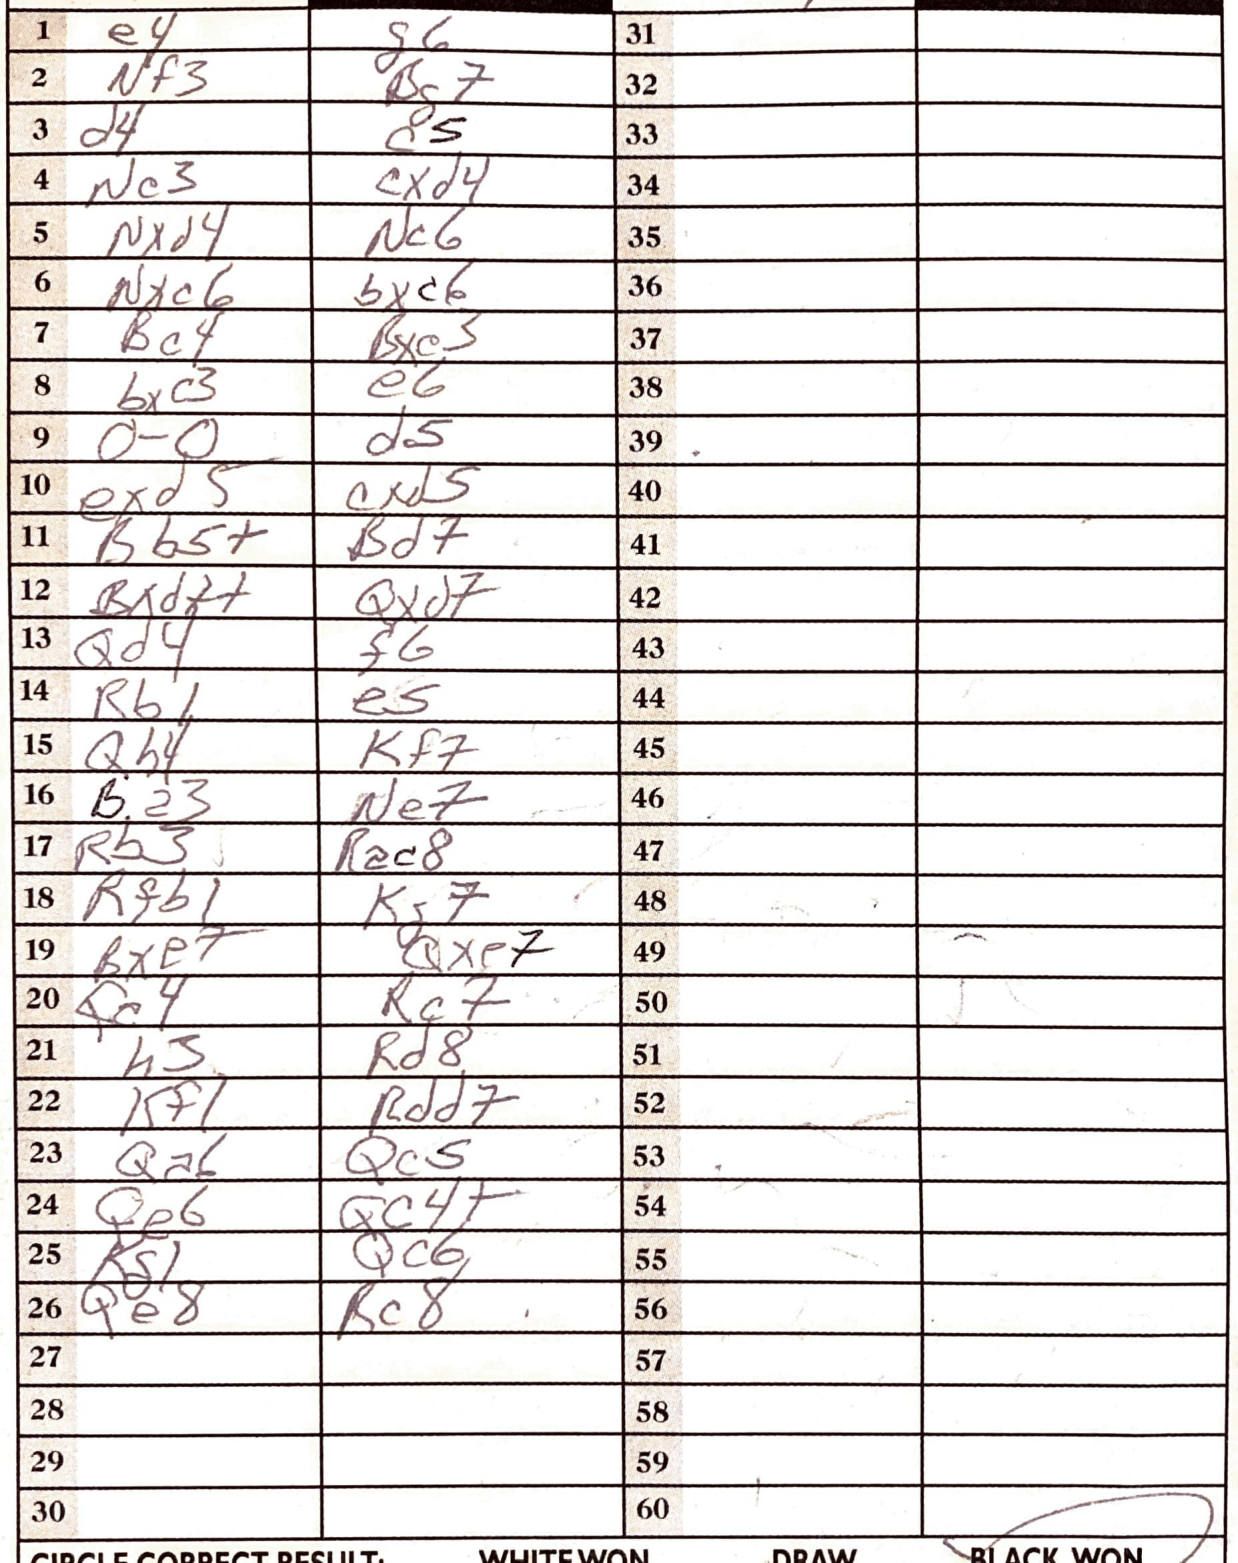

In [6]:
list_dataset[0]["image"]

### 2. Convert images to gray scale

In [7]:
list_of_gray_scaled = preprocess_strategy.process_image_dataset_rgb_to_grayscale(list_dataset)

2025-05-07 09:54:45,606 - src.classes_for_steps.preprocessing_strategy - INFO - All images in the list were successfully processed into gray scale format!
2025-05-07 09:54:45,606 - src.classes_for_steps.preprocessing_strategy - INFO - All images in the list were successfully processed into gray scale format!


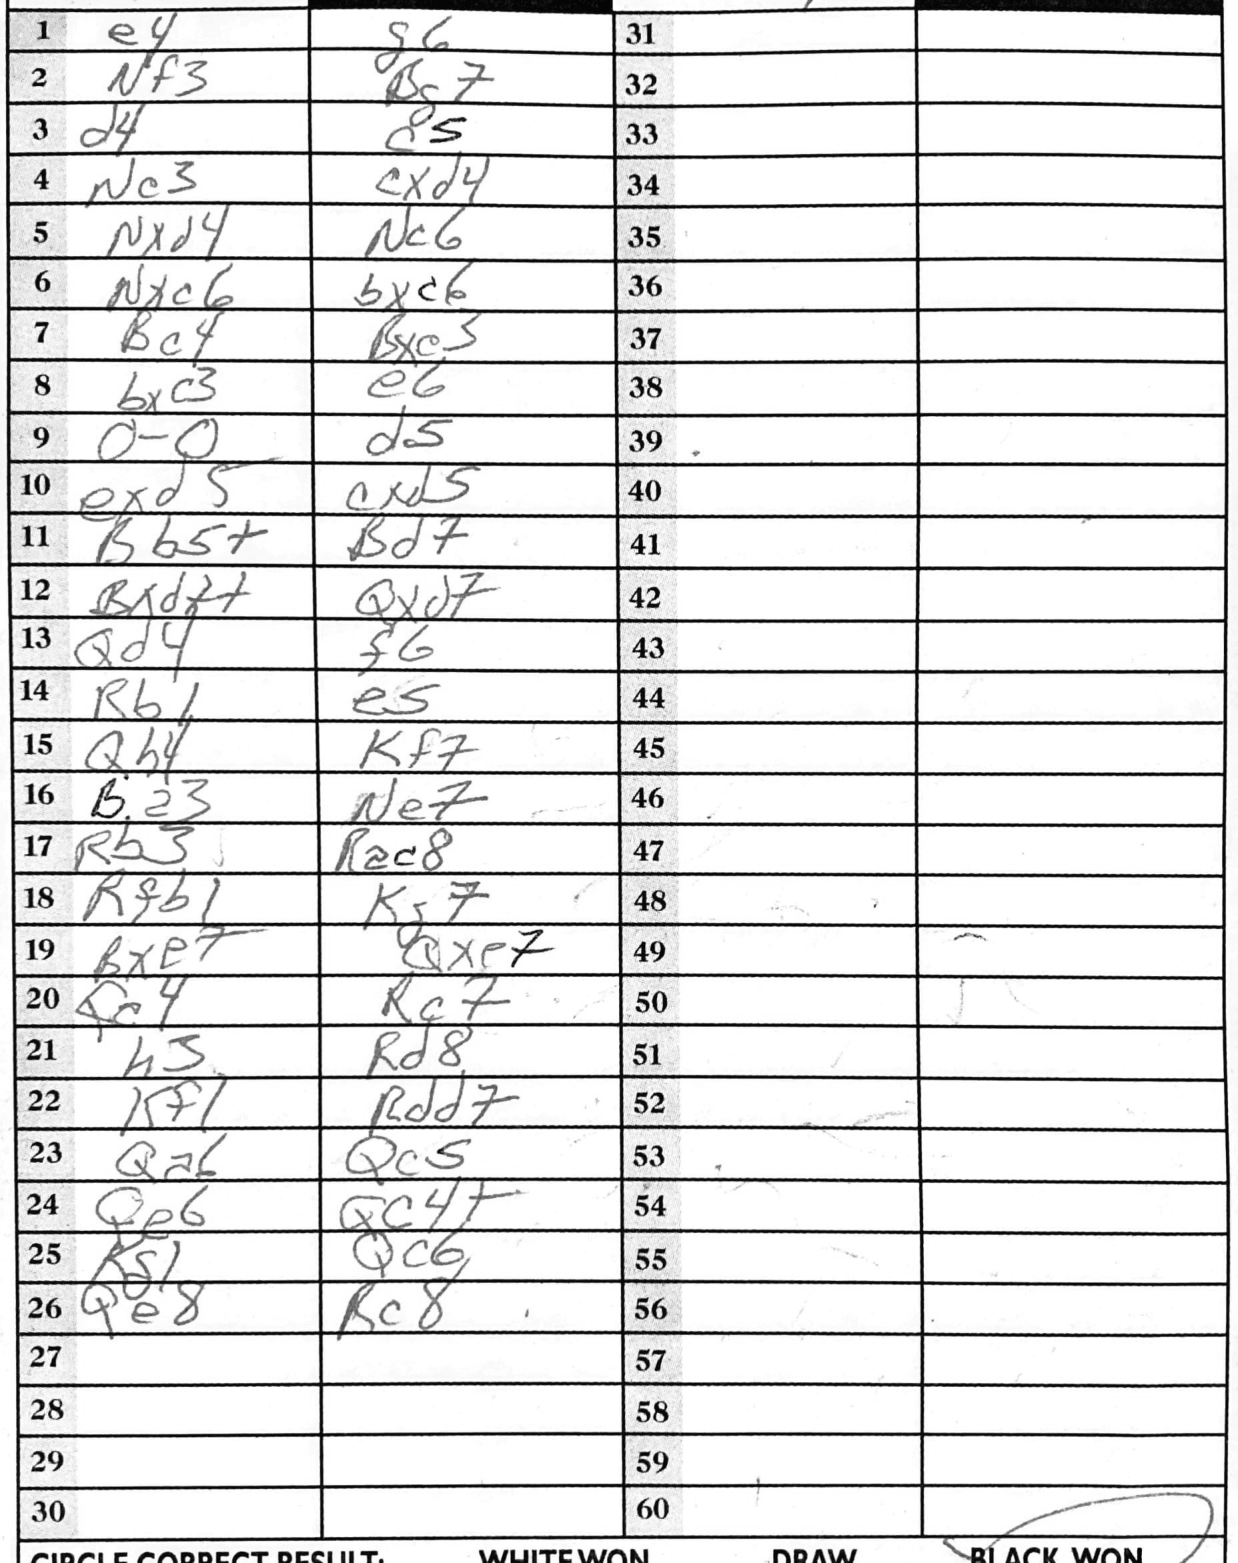

In [8]:
list_of_gray_scaled[0]["image"]

a### 3. Convert gray-scale images to binary images with otsu's method

In [9]:
list_of_binary_images = preprocess_strategy.process_image_dataset_gray_scaled_to_binary_with_threshold(list_of_gray_scaled)

2025-05-07 09:54:46,665 - src.classes_for_steps.preprocessing_strategy - INFO - 206 out of 206 images in the list were successfully processed into binary scale format with an average threshold of 149.21 and 0 where assigned with "image":None!
2025-05-07 09:54:46,665 - src.classes_for_steps.preprocessing_strategy - INFO - 206 out of 206 images in the list were successfully processed into binary scale format with an average threshold of 149.21 and 0 where assigned with "image":None!


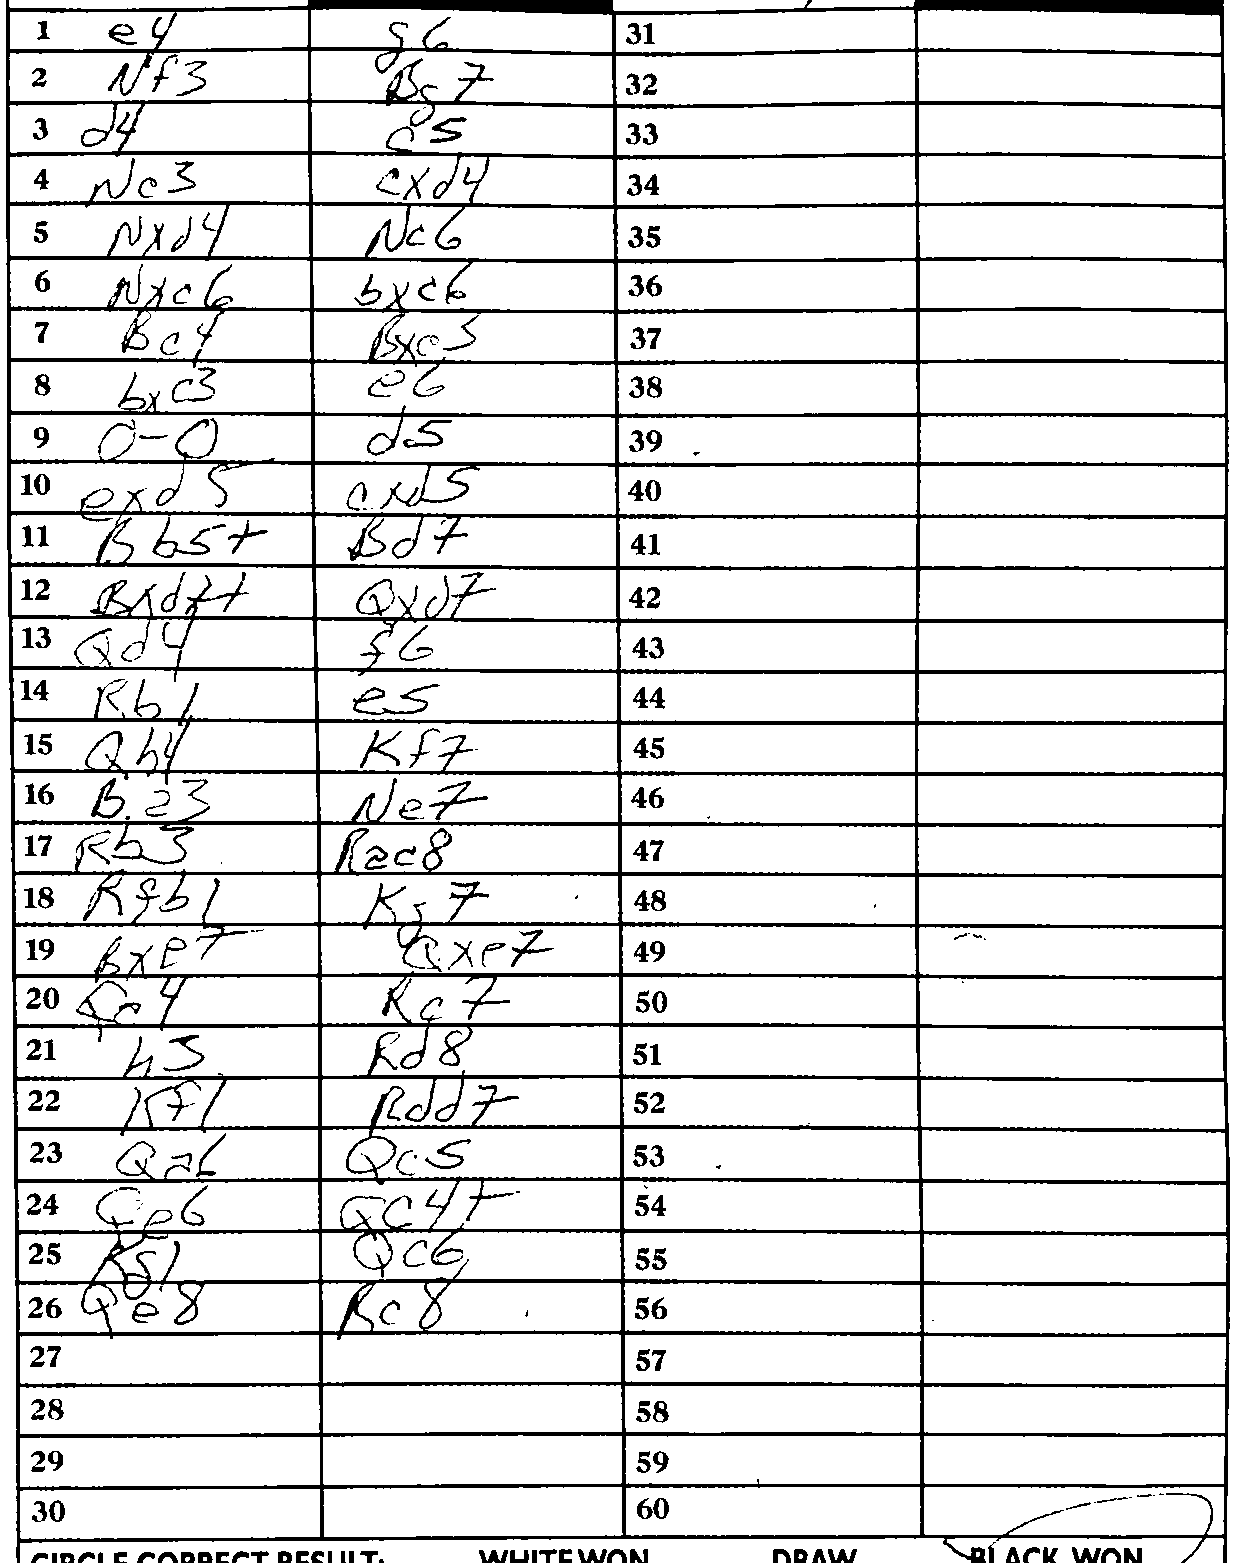

In [10]:
list_of_binary_images[0]["image"]

### 4. Generate image containing only grid lines

In [11]:
list_of_only_grid_lines = preprocess_strategy.process_image_dataset_binary_to_grid_lines(list_of_binary_images)

2025-05-07 09:54:50,205 - src.classes_for_steps.preprocessing_strategy - INFO - 206 out of 206 images in the list were successfully processed into binary scale images with grid lines and 0 where assigned with "image":None!
2025-05-07 09:54:50,205 - src.classes_for_steps.preprocessing_strategy - INFO - 206 out of 206 images in the list were successfully processed into binary scale images with grid lines and 0 where assigned with "image":None!


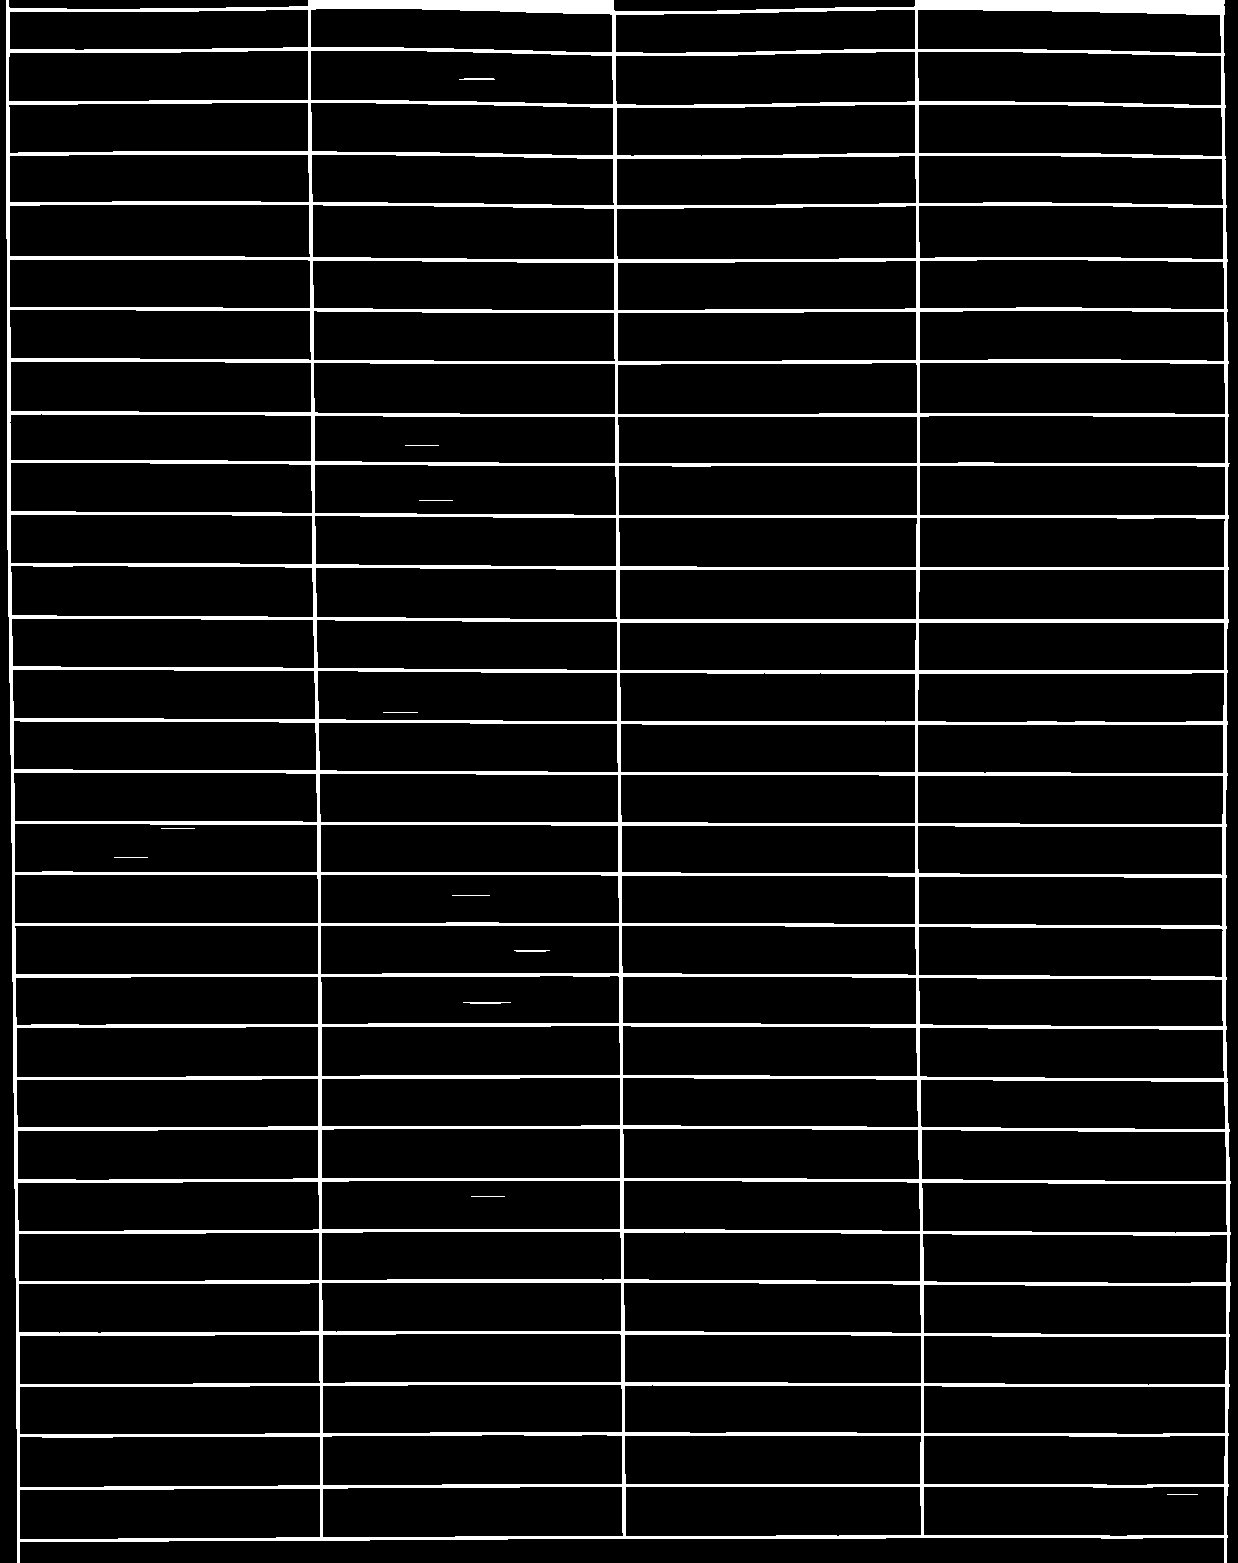

In [12]:
list_of_only_grid_lines[0]["image"]

### 5. Contour Algorithm

#### Whole Dataset

In [13]:
column_for_contours = "list_of_contours"
column_for_labels = "labels"
list_of_contour_list_per_image = preprocess_strategy.generate_image_dataset_binary_grid_to_list_of_contours(list_of_only_grid_lines, column_for_contours, column_for_labels)

2025-05-07 09:54:50,311 - src.classes_for_steps.preprocessing_strategy - ERROR - Error during processing image with index 2 with error: 117 are not enough contours found. Should be 120!
2025-05-07 09:54:50,311 - src.classes_for_steps.preprocessing_strategy - ERROR - Error during processing image with index 2 with error: 117 are not enough contours found. Should be 120!
2025-05-07 09:54:50,324 - src.classes_for_steps.preprocessing_strategy - ERROR - Error during processing image with index 3 with error: 114 are not enough contours found. Should be 120!
2025-05-07 09:54:50,324 - src.classes_for_steps.preprocessing_strategy - ERROR - Error during processing image with index 3 with error: 114 are not enough contours found. Should be 120!
2025-05-07 09:54:50,335 - src.classes_for_steps.preprocessing_strategy - ERROR - Error during processing image with index 4 with error: 117 are not enough contours found. Should be 120!
2025-05-07 09:54:50,335 - src.classes_for_steps.preprocessing_strategy

#### Single image

In [ ]:
contours = preprocess_strategy.generate_binary_grid_image_to_list_of_contours(list_of_only_grid_lines[0]["image"])

In [ ]:
print(len(contours))

In [ ]:
np_img = np.array(list_of_only_grid_lines[1]["image"])
np_img_with_contours = cv2.drawContours(np_img, contours, -1, (255, 255, 255), 30)

In [ ]:
plt.imshow(np_img_with_contours)

### 6. Cut out boxes with padding, give them a name and map them to the corresponding label

#### Whole Dataset

In [14]:
column_for_contours = "list_of_contours"
image_column = "image"
label_column = "labels"
dataset_move_boxes_with_labels = (
    preprocess_strategy.generate_from_contour_list_and_image_list_cut_out_image_to_label_dataset(
        list_of_contour_list_per_image, column_for_contours, list_of_gray_scaled, image_column, label_column))

2025-05-07 09:54:53,881 - src.classes_for_steps.preprocessing_strategy - INFO - 206 out of 206 images in the list were successfully processed into a list of move boxes and 0 where assigned with "image":None!
2025-05-07 09:54:53,881 - src.classes_for_steps.preprocessing_strategy - INFO - 206 out of 206 images in the list were successfully processed into a list of move boxes and 0 where assigned with "image":None!


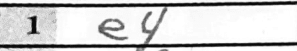

In [15]:
dataset_move_boxes_with_labels[0]["image"]

In [16]:
print(dataset_move_boxes_with_labels[0]["label"])

e4


#### Single Image

In [ ]:
import src.classes_for_steps.preprocessing_strategy

importlib.reload(src.classes_for_steps.preprocessing_strategy)
preprocess_strategy = src.classes_for_steps.preprocessing_strategy.HuggingFacePreprocessingStrategy()

In [ ]:
img = list_dataset[0]["image"]

In [ ]:
contours = preprocess_strategy.generate_binary_grid_image_to_list_of_contours(list_of_only_grid_lines[0]["image"])
cut_out_image = preprocess_strategy.generate_from_four_contour_points_and_image_a_cut_out_image(contours[0], img)

In [ ]:
cut_out_image

In [ ]:
list_dataset[0]["labels"][0]